One of the new functionalities I added in ArviZ during my GSoC internship is Leave One Out (LOO) Probability Integral Transform (PIT) marginal posterior predictive checks. You can see [two](https://arviz-devs.github.io/arviz/examples/plot_loo_pit_ecdf.html) [examples](https://arviz-devs.github.io/arviz/examples/plot_loo_pit_overlay.html) of its usage in the example gallery and also some examples in its [API section](https://arviz-devs.github.io/arviz/generated/arviz.plot_loo_pit.html#arviz.plot_loo_pit). However, these examples are mainly related to the usage of the functionalities, not so much on the usage of LOO-PIT itself nor its interpretability.

I feel that the LOO-PIT algorithm usage and interpretability needs a short summary with examples showing the most common issues found when checking models with LOO-PIT. This tutorial will tackle this issue: how can LOO-PIT be used for model checking and what does it tell us in a practical manner, so we can see firsthand how wrongly specified models cause LOO-PIT values to differ from a uniform distribution. For information on what exactly is LOO-PIT doing see:

* Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., and Rubin, D. B. (2013). Bayesian Data Analysis. Chapman & Hall/CRC Press, London, third edition. (p. 152-153)

We will use LOO-PIT checks alog with non-marginal posterior predictive checks as implemented in ArviZ. This will allow to see some differences between the two kinds of posterior predictive checks as well as to provide some intuition to cases where one may be best and cases where both are needed.

Here, we will experiment with LOO-PIT using two different models. First an estimation of the mean and standard deviation of a 1D Gaussian variable, and then a 1D linear regression. Afterwards, we will see how to use LOO-PIT checks with multivariate data.

In [1]:
import pymc3 as pm
import numpy as np
import arviz as az 
import matplotlib.pyplot as plt
import theano.tensor as tt

import scipy.stats as stats

np.random.seed(7)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.style.use('../forty_blog.mplstyle')

In [3]:
def plot_ppc_loopit(idata):
    fig = plt.figure(figsize=(12,9))
    ax_ppc = fig.add_subplot(211)
    ax1 = fig.add_subplot(223); ax2 = fig.add_subplot(224)
    az.plot_ppc(idata, ax=ax_ppc);
    for ax, ecdf in zip([ax1, ax2], (False, True)):
        az.plot_loo_pit(idata, y="obs", ecdf=ecdf, ax=ax);
    return np.array([ax_ppc, ax1, ax2])

In [4]:
N_obs = 170
mu_normal = -2
sd_normal = 3
data_normal = np.random.normal(loc=mu_normal, scale=sd_normal, size=N_obs)
a0_lr, a1_lr = 5, -2.3
sd_lr = 1.4
data_x_regression = np.linspace(0, 10, N_obs)
data_y_regression = np.random.normal(loc=a1_lr*data_x_regression+a0_lr, scale=sd_lr)

In [5]:
coords_normal = {"obs": ["observation"], "log_likelihood": ["observation"]}
dims_normal = {"observation": range(N_obs)}
coords_regression = {"y": ["time"], "log_likelihood": ["time"]}
dims_regression = {"time": data_x_regression}

We will now plot the two datsets generated, to give graphical an idea of the data we are working with.

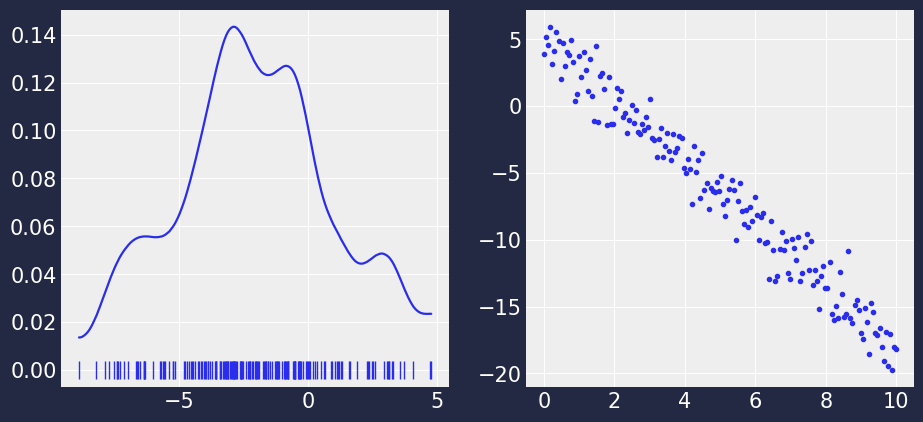

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(11,5))
textsize = plt.rcParams["axes.labelsize"]
az.plot_dist(data_normal, rug=True, ax=axes[0], rug_kwargs={"space": 0}, textsize=textsize);
axes[1].plot(data_x_regression, data_y_regression, ".");
axes[1].tick_params(labelsize=textsize)

## Estimating the parameters of a Gaussian random variable
We will start with a model that correctly fits with the data, to show how should both checks look like. Afterwards, we will see cases were these checks deviate from this ideal case and give some hints on how to interpret these deviations.

In [7]:
with pm.Model() as model:
    # Define priors
    mu = pm.Normal("mu", mu=0, sd=10)
    sd = pm.HalfNormal("sd", sd=10)
    
    # Define likelihood
    likelihood = pm.Normal("obs", mu=mu, 
                        sd=sd, observed=data_normal)
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)

idata_normal = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_normal,
    dims=dims_normal,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mu]
100%|██████████| 2000/2000 [00:01<00:00, 1421.25it/s]


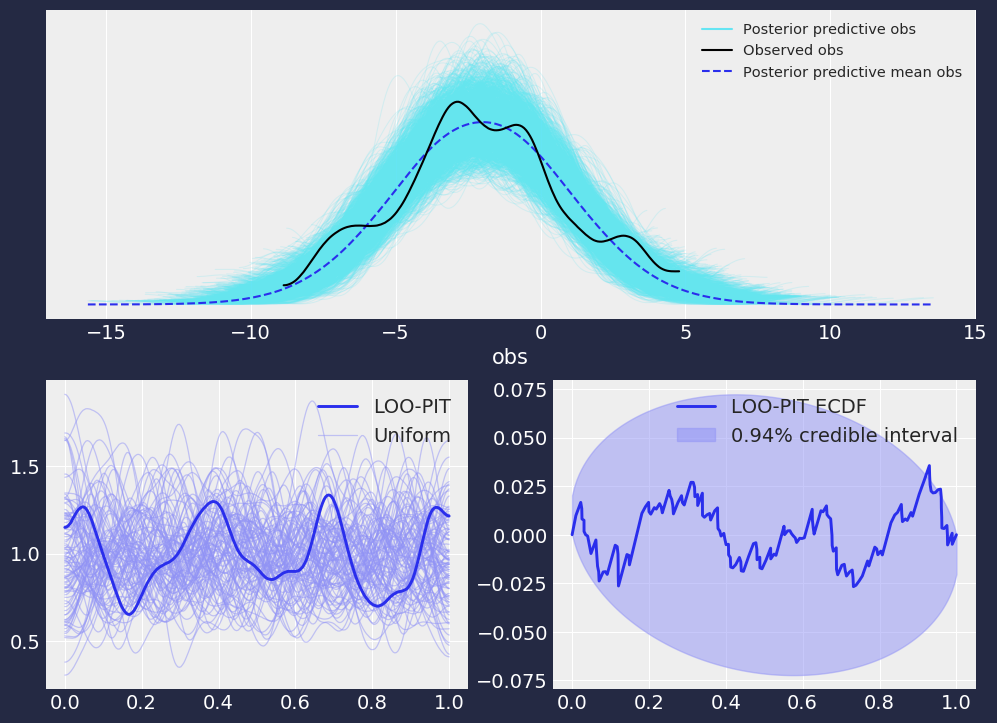

In [8]:
plot_ppc_loopit(idata_normal);

To begin with, it can be seen that the observed KDE is similar to the overlayed posterior predictive KDEs. The same happens with the LOO-PIT values; the LOO-PIT KDE is similar to the overlayed uniform KDEs. Thus, in this first example, similar information can be obteined from their interpretation.

We will now move to one common mismatch between the model and the observed data. We will perform the same fit as the previous example but fixing the standard deviation of the normal random variable. This is actually not an unrealistic case, as in many cases where the instrument used to measure gives error data in addition to the measure, this error is used to fix the standard deviation.

These two examples show how the LOO-PIT looks like for overdispersed models (i.e. the error is assumed to be larger than what it actually is) and for underdispersed models (i.e. the error is assumed to be smaller than what it really is).

In [9]:
with pm.Model() as model:
    # Define priors
    mu = pm.Normal("mu", mu=0, sd=10)
    
    # Define likelihood
    likelihood = pm.Normal(
        "obs", mu=mu, sd=1.5 * sd_normal, observed=data_normal
    )
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_normal_overdispersed = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_normal,
    dims=dims_normal,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
100%|██████████| 2000/2000 [00:00<00:00, 2945.07it/s]


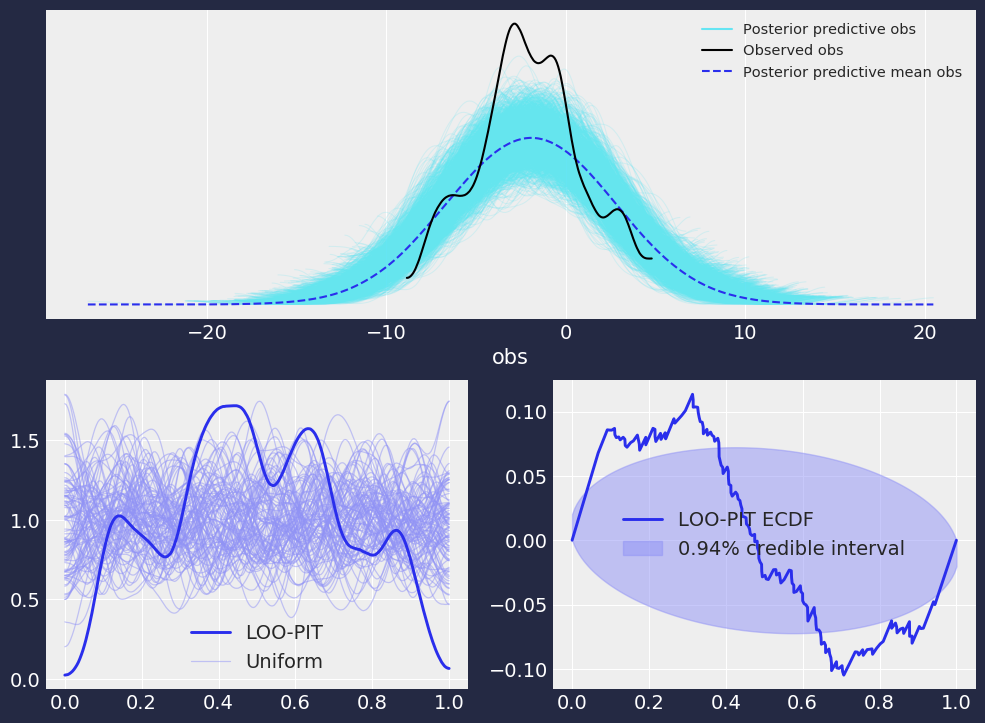

In [10]:
plot_ppc_loopit(idata_normal_overdispersed);

In this example of overdispersed model, we can see that the posterior predictive checks show that the observed KDE is narrower than most of the posterior predictive KDEs and narrower than the mean KDE of the posterior predictive samples. However, there are still some posterior predictive samples whose KDEs are similar to the observed KDE. In the LOO-PIT check though, there is no room for confursion. There is no overlayed distribution as extreme as the LOO-PIT KDE, and the difference between the Empirical Cumulative Density Function (ECDF) and the ideal uniform CDF lays outside the envelope most of the time.

In [11]:
with pm.Model() as model:
    # Define priors
    mu = pm.Normal("mu", mu=0, sd=10)
    
    # Define likelihood
    likelihood = pm.Normal(
        "obs", mu=mu, sd=.75 * sd_normal, observed=data_normal
    )
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_normal_underdispersed = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_normal,
    dims=dims_normal,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
100%|██████████| 2000/2000 [00:00<00:00, 2918.68it/s]


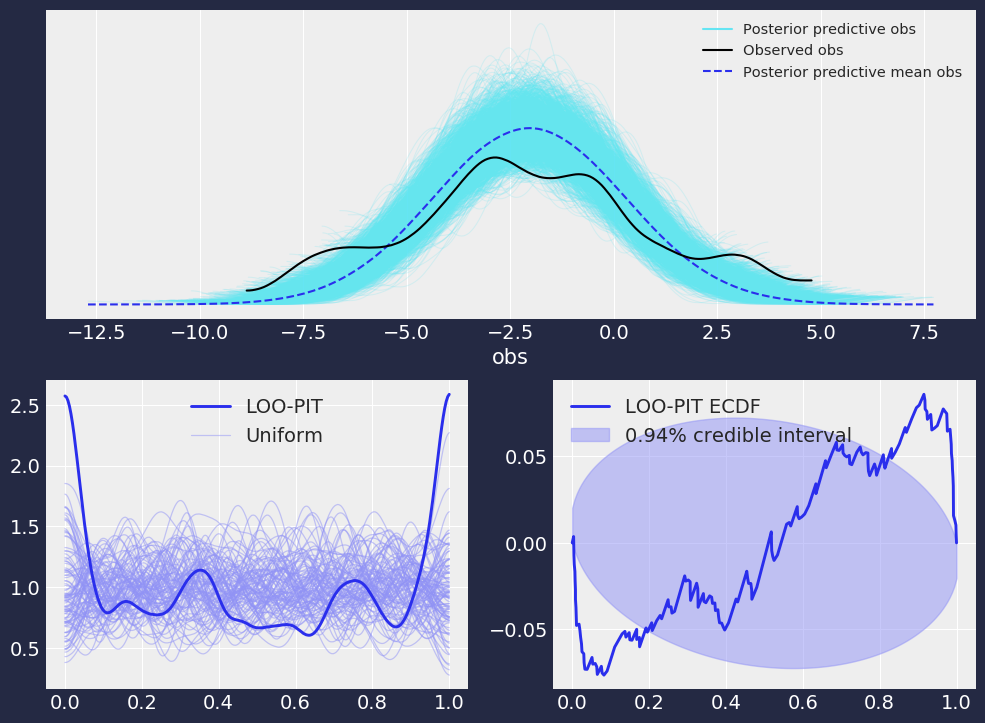

In [12]:
plot_ppc_loopit(idata_normal_underdispersed);

Here, the differences are similar to the overdispersed case, modifying overdispersed by underdispersed. It is important to note though, that the LOO-PIT itself already indicates the problem with the model: a convex shape (or an N in the ECDF difference plot) is a sign of an underdispersed model, and a concave shape (or an inverted-N ECDF difference) is a sign of underdispersion.

In addition, LOO-PIT checks also show signs of model bias, as shown in the following example:

In [13]:
with pm.Model() as model:
    # Define priors
    sd = pm.HalfNormal("sd", sd=10)
    
    # Define likelihood
    likelihood = pm.Normal(
        "obs", mu=mu_normal - sd_normal / 2, sd=sd, observed=data_normal
    )
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_normal_bias = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_normal,
    dims=dims_normal,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd]
100%|██████████| 2000/2000 [00:01<00:00, 1490.14it/s]


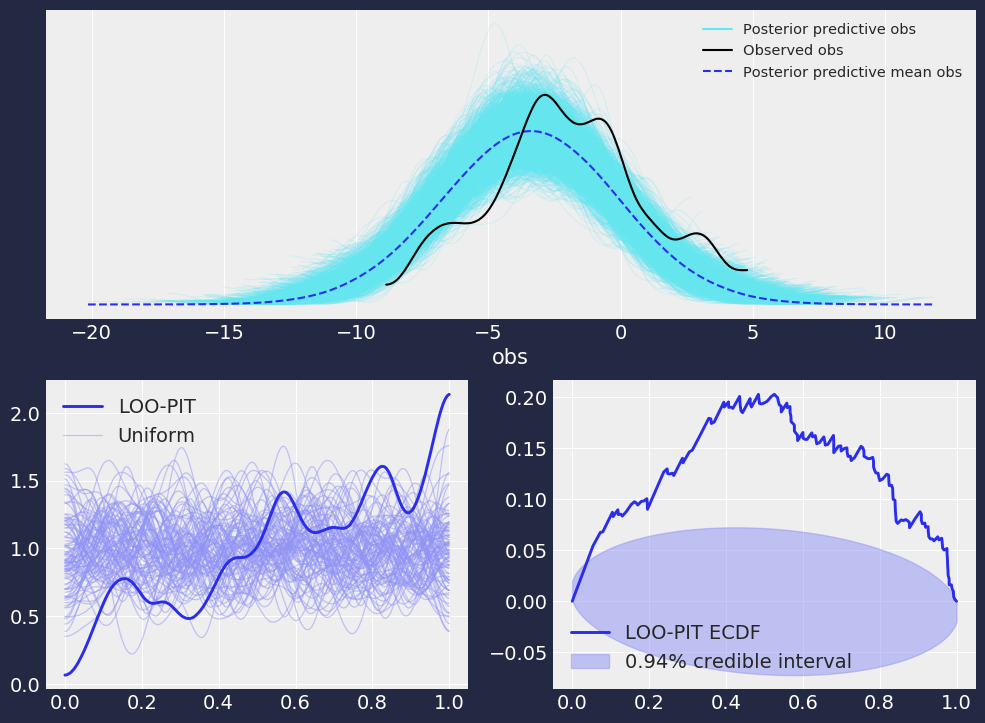

In [14]:
plot_ppc_loopit(idata_normal_bias);

## Linear regression
In the case of a linear regression, the posterior predictive checks direclty do not give us much information, because each datapoint is centered at a different location, so combining them to create a single KDE won't yield useful results. 
It is important to note though, that this is not an issue inherent to the posterior predictive checks, and could be solved by rescaling each observation by substracting the mean and divide by the standard deviation along every observation from the posterior predictive. We will also include an example of this kind of transformation in the last example, but there should not be much to worry about as this improvement is on the ArviZ roadmap.

In [15]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfNormal('sigma', sd=10)
    a0 = pm.Normal("a0", mu=0, sd=20)
    a1 = pm.Normal("a1", mu=0, sd=20)
    
    # Define likelihood
    likelihood = pm.Normal('obs', mu=a0 + a1 * data_x_regression, 
                        sd=sigma, observed=data_y_regression)
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_lr = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_regression,
    dims=dims_regression,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a0, sigma]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2454.06draws/s]
The acceptance probability does not match the target. It is 0.8878515682888283, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:01<00:00, 1020.01it/s]


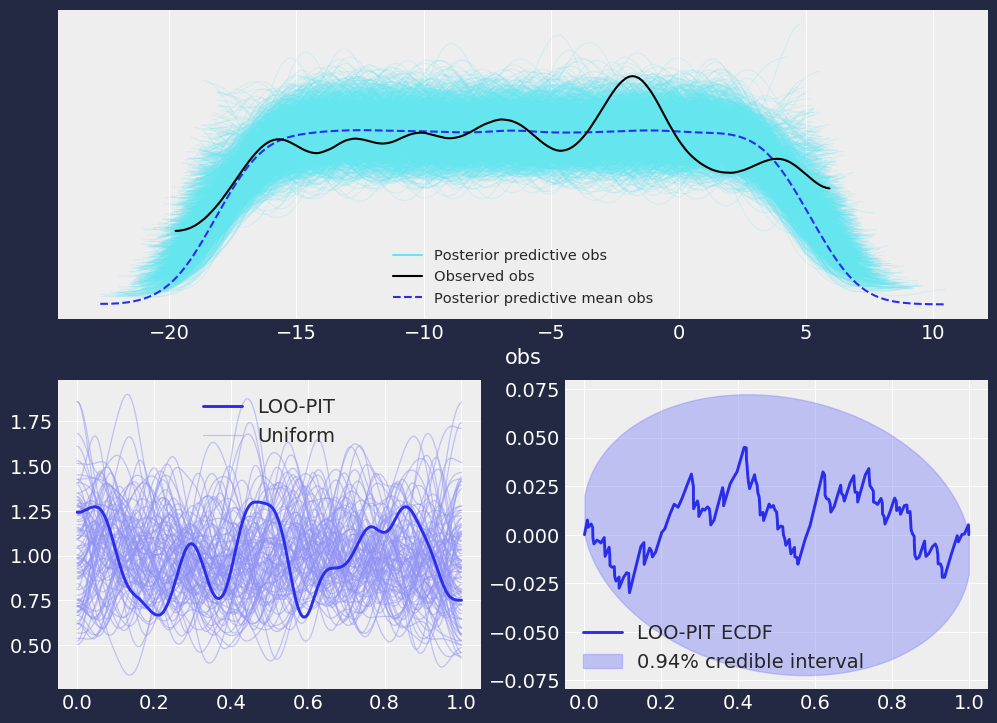

In [16]:
plot_ppc_loopit(idata_lr);

Now let's see how does introducing some small bias modifies the results.

In [17]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfNormal('sigma', sd=10)
    a1 = pm.Normal("a1", mu=0, sd=20)
    
    # Define likelihood
    likelihood = pm.Normal('obs', mu=a0_lr + 2 + a1 * data_x_regression, 
                        sd=sigma, observed=data_y_regression)
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_lr_bias = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_regression,
    dims=dims_regression,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, sigma]
100%|██████████| 2000/2000 [00:01<00:00, 1017.33it/s]


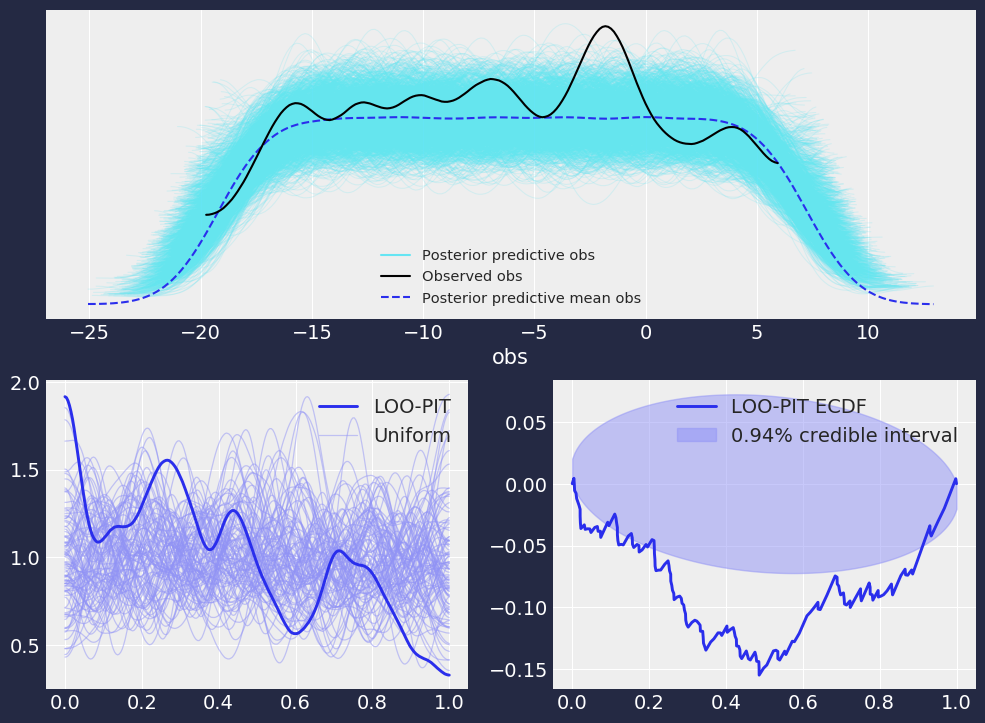

In [18]:
plot_ppc_loopit(idata_lr_bias);

Now the LOO-PIT check is clearly showing signs of bias in the model, whereas due to the lack of rescaling, no bias is seen in the posterior predictive checks.

Finally, let's combine some bias with overdispersion, to see how is LOO-PIT modified. Moreover, we will rescale the posterior predictive data to see how would rescaling affect the posterior predictive checks.

In [19]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    a1 = pm.Normal("a1", mu=0, sd=20)
    
    # Define likelihood
    likelihood = pm.Normal('obs', mu=a0_lr + 2 + a1 * data_x_regression, 
                        sd=1.5 * sd_lr, observed=data_y_regression)
    
    # Inference!
    trace = pm.sample() # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace)
    
idata_lr_bias_overdispersed = az.from_pymc3(
    trace=trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    coords=coords_regression,
    dims=dims_regression,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1]
100%|██████████| 2000/2000 [00:01<00:00, 1556.69it/s]


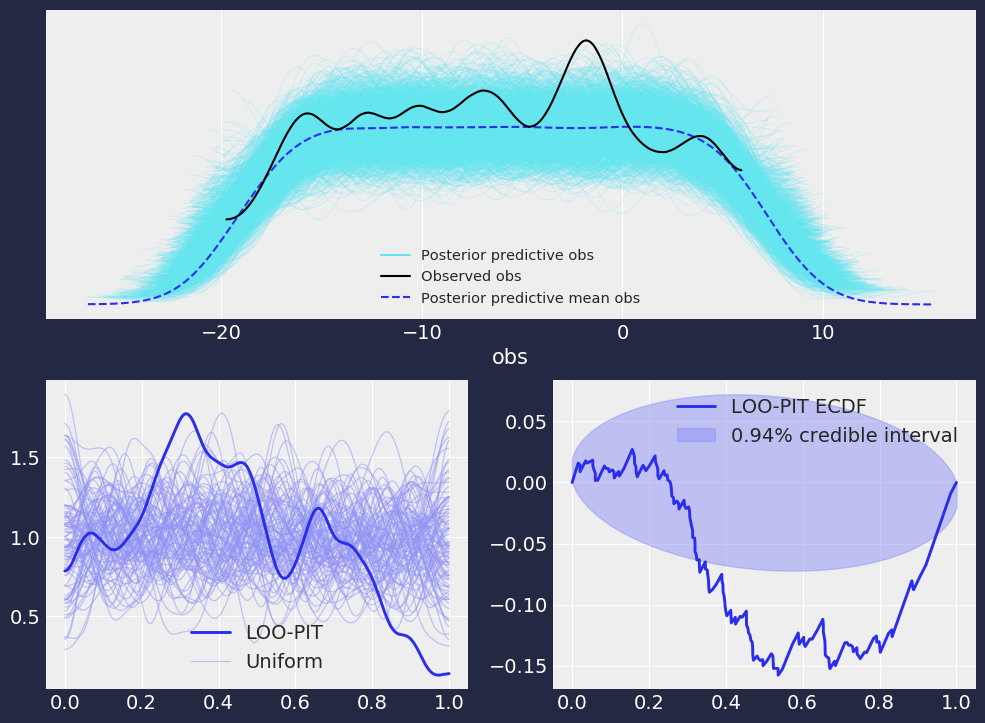

In [20]:
plot_ppc_loopit(idata_lr_bias_overdispersed);

In [21]:
pp_samples = idata_lr_bias_overdispersed.posterior_predictive.obs
obs_samples = idata_lr_bias_overdispersed.observed_data.obs
pp_means = pp_samples.mean(dim=("chain", "draw"))
pp_stds = pp_samples.std(dim=("chain", "draw"))
idata_lr_bias_overdispersed.posterior_predictive["obs_rescaled"] = (pp_samples - pp_means) / pp_stds
idata_lr_bias_overdispersed.observed_data["obs_rescaled"] = (obs_samples - pp_means) / pp_stds

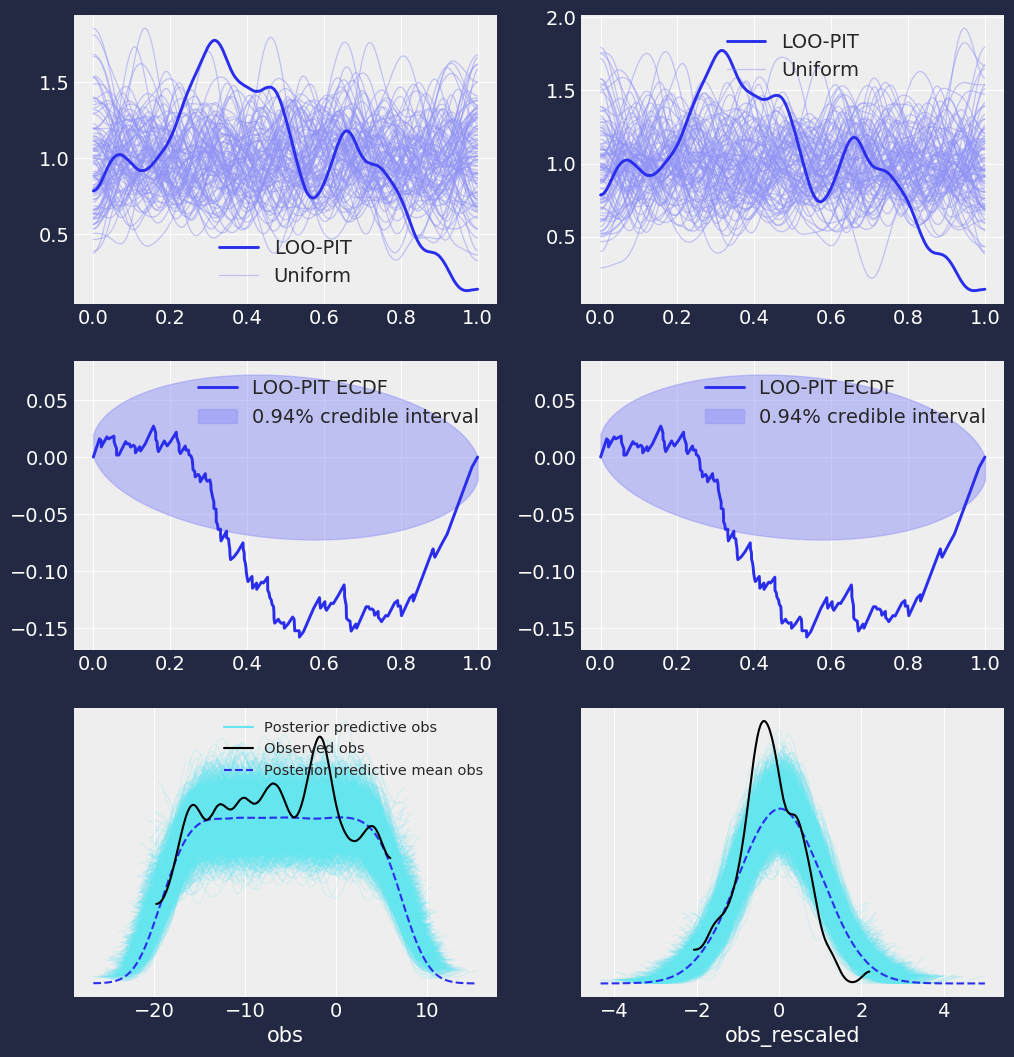

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(12,13))
for i, var in enumerate(("obs", "obs_rescaled")):
    for j, ecdf in enumerate((False, True)):
        az.plot_loo_pit(idata_lr_bias_overdispersed, y=var, ecdf=ecdf, ax=axes[j, i]);
az.plot_ppc(idata_lr_bias_overdispersed, ax=axes[2]);

As you can see, the posterior predictive check for `obs_rescaled` does indicate overdispersion and bias of the posterior predictive samples, whereas the one for `obs` does not, following what we were seeing previously. The LOO-PIT checks do not change one bit however. This is actually a property of the LOO-PIT algorithm. As it is comparing the marginal distributions of the posterior predictive and the observed data using the MCMC samples, any _monotonous_ transformation will not modify its value because it won't modify the order between the samples. Therefore, if the observed data is larger than 36% of the posterior predictive samples, the rescaling we have done does not modify this fact.

This bring us to the next topic. What if we were sampling a multidimensional gaussian or doing a multivariate linear regression? Then the LOO-PIT cannot be used directly, because the shape of the posterior predictive samples and that of the likelihood is not the same.

## LOO-PIT checks on multivariate data
Our last example will be a multivariate linear regression. We have $N=4$ dependent variables ($X$) from which we want to estimate the value of $M=3$ dependent variables ($Y$), which can be modelled as a multivariate normal variable. To get a proper estimate, we perform $N_{obs}$ observations of each variable.

Therefore, our model will be $Y \sim \text{MvNormal}(\mu, \Sigma)$, with the variable $Y \in \mathbb{R}^{N_{obs}\times M}$, its means $\mu \in \mathbb{R}^{N_{obs}\times M}$ and the covariance matrix $\Sigma \in \mathbb{R}^{M \times M}$. $\mu = X B$ is calculated from the dependent variables $X \in \mathbb{R}^{N_{obs}\times N}$ and the regression parameters $B \in \mathbb{R}^{N \times M}$.

In [23]:
N_obs = 80  # looped over with k
N = 4  # independent variables, looped over with i
M = 3  # dependent variables, looped over with j
dims = {
    "B": ["independent_var", "dependent_var"], 
    "obs": ["observation", "dependent_var"], 
    "log_likelihood": ["observation"]}
X_obs = np.stack([np.linspace(i,i+1, N_obs) for i in range(N)]).T
B_true = np.random.normal(scale=3, size=(N, M))
true_cov = np.array([[1.0, 0.5, 0.1],
                     [0.5, 2.0, 0.2],
                     [0.1, 0.2, 1.0]])
mu_true = np.dot(X_obs, B_true)
data = np.stack([np.random.multivariate_normal(mu_true[k], true_cov) for k in range(N_obs)])

In [24]:
with pm.Model() as model:
    # Note that we access the distribution for the standard
    # deviations, and do not create a new random variable.
    X = pm.Data("X", X_obs)
    sd_dist = pm.HalfCauchy.dist(beta=2.5)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=M, sd_dist=sd_dist)
    chol = pm.expand_packed_triangular(M, packed_chol, lower=True)

    # Define a new MvNormal with the given covariance
    B = pm.Normal("B", sigma=3, shape=(N, M))
    mu = tt.dot(X, B)
    vals = pm.MvNormal("obs", mu=mu, chol=chol, observed=data)
    trace = pm.sample()
    posterior_predictive = pm.sample_posterior_predictive(trace)

idata_mv_normal = az.from_pymc3(trace=trace, posterior_predictive=posterior_predictive, dims=dims)

/home/oriol/venvs/random/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/oriol/venvs/random/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/oriol/venvs/random/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for mult

In these model, each observation is multivariate, thus, the shape of the posterior predictive $(N_{chains}, N_{draws}, N_{obs}, M)$ and the shape of the log likelihood $(N_{chains}, N_{draws}, N_{obs})$ are not the same, preventing us from using LOO-PIT checks directly.

In [25]:
print("pp shape: ", idata_mv_normal.posterior_predictive.obs.shape)
print("log_like shape: ", idata_mv_normal.sample_stats.log_likelihood.shape)

pp shape:  (4, 500, 80, 3)
log_like shape:  (4, 500, 80)


To be able to use LOO-PIT checks, we have to combine the multivariate observations into an scalar value. This is actually applying a Bayesian test function as an observation-wise function. We will use 3 different functions, the minimum, the mean and the maximum, but we could have used any scalar function. If $M$ were larger, quantile values could be used, we could also check the LOO-PIT of each dependent variable... It has the same freedom as Bayesian test functions. For more information of Bayesian test functions see:

* Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., and Rubin, D. B. (2013). Bayesian Data Analysis. Chapman & Hall/CRC Press, London, third edition. (p. 146-149)

The first step is to calculate the test function value and store it in the posterior predictive and observed data groups.

In [26]:
# minimum
idata_mv_normal.posterior_predictive["T_min"] = idata_mv_normal.posterior_predictive.obs.min(dim="dependent_var")
idata_mv_normal.observed_data["T_min"] = idata_mv_normal.observed_data.obs.min(dim="dependent_var")

# mean
idata_mv_normal.posterior_predictive["T_mean"] = idata_mv_normal.posterior_predictive.obs.mean(dim="dependent_var")
idata_mv_normal.observed_data["T_mean"] = idata_mv_normal.observed_data.obs.mean(dim="dependent_var")

# maximum
idata_mv_normal.posterior_predictive["T_max"] = idata_mv_normal.posterior_predictive.obs.max(dim="dependent_var")
idata_mv_normal.observed_data["T_max"] = idata_mv_normal.observed_data.obs.max(dim="dependent_var")

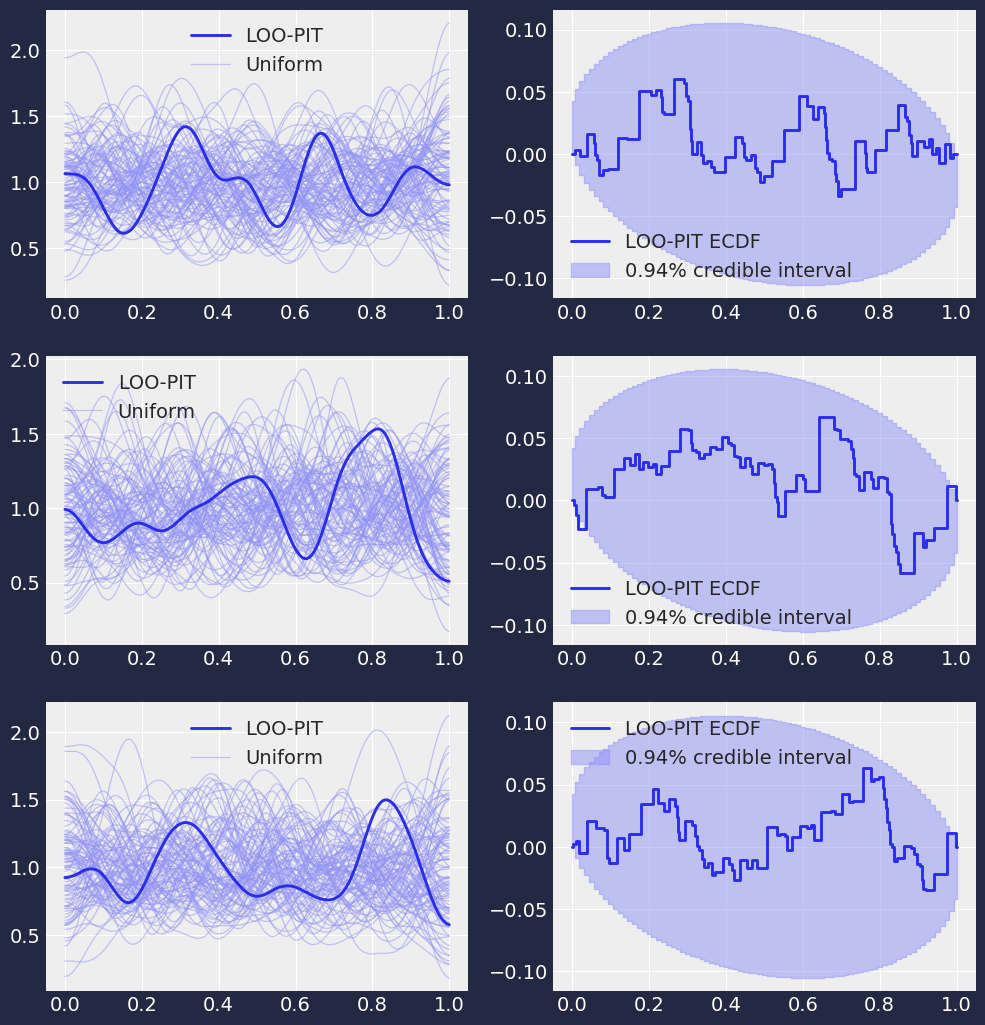

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(12,13))
for row, var in enumerate(("T_min", "T_mean", "T_max")):
    for col, ecdf in enumerate((False, True)):
        az.plot_loo_pit(idata_mv_normal, y=var, ecdf=ecdf, ax= axes[row, col]);

Now all 3 LOO-PIT checks are different and bring new information to the table. This is because the functions applied to the posterior predictive and observed data samples are not monotonous transformations, they do modify the relative order between the samples giving each its LOO-PIT values. In this case, as expected because the data is simulated and we are using the same model for analysis and for data generation, all 3 LOO-PIT checks look good.